In [23]:
import holidays
import numpy as np
import pandas as pd
import seaborn as sns
import optuna
import matplotlib.pyplot as plt

from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

import warnings
warnings.filterwarnings('ignore')

# import data

In [24]:
df = pd.read_csv("../data/PJME_hourly.csv", parse_dates=["Datetime"]).rename(
    columns={'Datetime': 'ds', 'PJME_MW': 'y'}
)

# feature engineering

In [25]:
def create_features(df):
    """
    Create temporal features from the datetime column.
    """
    # Temporal features
    df['hour'] = df['ds'].dt.hour
    df['day_of_week'] = df['ds'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

    # Quarterly (annual) features 
    quarters = {
        1: 'Q1_Jan-Mar',
        2: 'Q2_Apr-Jun', 
        3: 'Q3_Jul-Sep',
        4: 'Q4_Oct-Dec'
    }
    df['quarter'] = df['ds'].dt.quarter.map(quarters)
    
    # Cyclical hour encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

    return df

# Apply feature engineering and drop missing values
df = create_features(df.dropna())

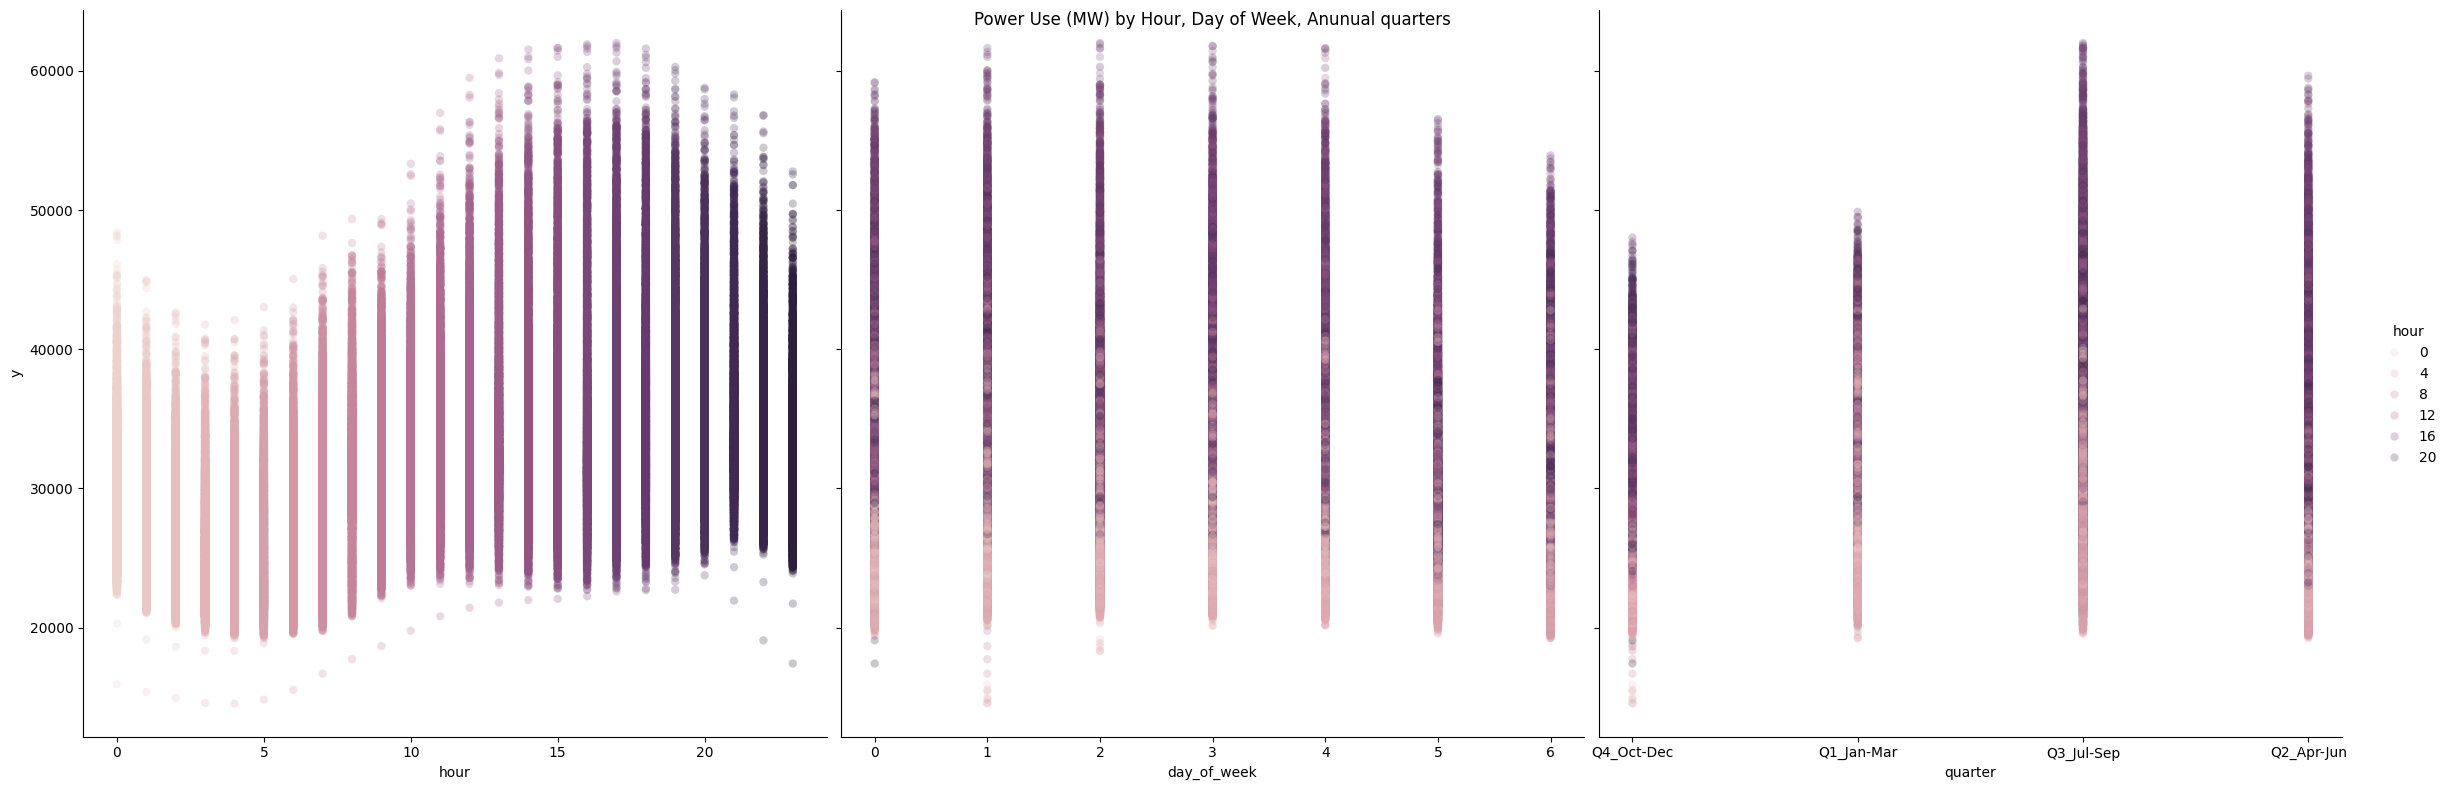

In [26]:
sns.pairplot(df,
             hue='hour',
             x_vars=['hour','day_of_week',
                     'quarter'],
             y_vars='y',
             height=8,
             plot_kws={'alpha':0.25, 'linewidth':0}
            )
plt.suptitle('Power Use (MW) by Hour, Day of Week, Anunual quarters')
plt.show()

In [28]:
# Global split into training and test sets
full_train, test_set = split_train_test('2015-01-01')

# Data Cleaning

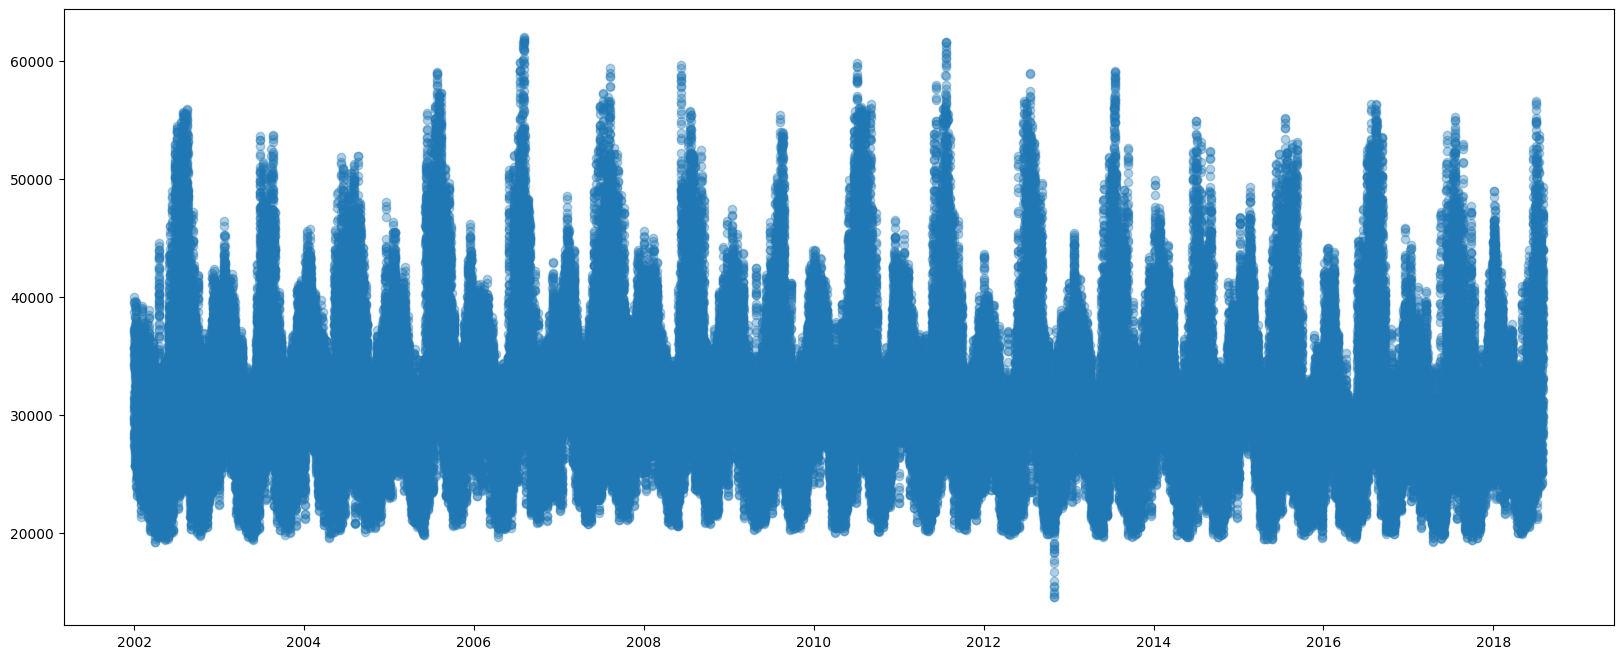

In [15]:
df_clean = df.copy()

fig, ax = plt.subplots(figsize=(20, 8))
ax.scatter(x=df_clean['ds'], y = df_clean['y'], alpha=0.35)
plt.show()

In [32]:
def clean_train_data(trial, train_df):
    """
    Clean training data by masking hurricane periods and imputing outliers.

    The function uses hyperparameter suggestions from the trial to:
      - Mask hurricane periods in the data (set to NaN).
      - Compute a rolling median and interquartile range (IQR) to detect outliers.
      - Impute detected outliers using the rolling median.

    Returns:
      df_clean (DataFrame): Cleaned training data with the column 'y' (cleaned values).
      hurricane_dates (DataFrame): DataFrame with hurricane dates and their lower/upper windows.
    """
    df_clean = train_df.copy()
    
    # Hyperparameter suggestions from the trial
    cleaning_params = {
        'window_size': trial.suggest_int('window_size', 24*3, 24*14),  # 3 days to 2 weeks
        'iqr_multiplier': trial.suggest_float('iqr_multiplier', 2.0, 5.0),
        'hurricane_window': trial.suggest_int('hurricane_window', 2, 5)  # Days around hurricane
    }
    
    # Define hurricane dates and corresponding windows
    hurricane_dates = pd.DataFrame({
        'holiday': 'hurricane',
        'ds': pd.to_datetime(['2012-10-29', '2017-09-10']),
        'lower_window': -cleaning_params['hurricane_window'],
        'upper_window': cleaning_params['hurricane_window']
    })
    
    # Mask hurricane periods by replacing values with NaN
    hurricane_periods = []
    for date in hurricane_dates['ds']:
        start = date - pd.Timedelta(days=cleaning_params['hurricane_window'])
        end = date + pd.Timedelta(days=cleaning_params['hurricane_window'])
        hurricane_periods.extend(pd.date_range(start, end))
    
    df_clean.loc[df_clean['ds'].isin(hurricane_periods), 'y'] = np.nan
    
    # Outlier detection using a rolling median and IQR
    temp_y = df_clean['y'].ffill().bfill()
    window_size = cleaning_params['window_size']
    df_clean['rolling_median'] = temp_y.rolling(window=window_size, center=True).median()
    df_clean['iqr'] = temp_y.rolling(window=window_size, center=True).apply(
        lambda x: np.percentile(x, 75) - np.percentile(x, 25), raw=True
    )
    
    # Flag outliers when the value deviates significantly from the rolling median
    df_clean['is_outlier'] = (
        (df_clean['y'] > (df_clean['rolling_median'] + cleaning_params['iqr_multiplier'] * df_clean['iqr'])) |
        (df_clean['y'] < (df_clean['rolling_median'] - cleaning_params['iqr_multiplier'] * df_clean['iqr']))
    ).astype(int)
    
    # Impute detected outliers with the rolling median
    df_clean['y_clean'] = np.where(df_clean['is_outlier'], df_clean['rolling_median'], df_clean['y'])
    df_clean['y_clean'] = df_clean['y_clean'].ffill().bfill()

    # Drop 'y' and rename 'y_clean' to 'y'
    df_clean = df_clean.drop('y', axis=1).rename(columns={'y_clean': 'y'})
    
    return df_clean, hurricane_dates


In [11]:
# # 1. Handle Known Hurricane Periods First
# hurricane_periods = pd.date_range('2012-10-28', '2012-11-01')  # Example dates
# df_clean['is_hurricane'] = df_clean['ds'].isin(hurricane_periods).astype(int)

# # 2. Temporary NaN for hurricane periods during outlier detection
# temp_y = df_clean['y'].mask(df_clean['is_hurricane'] == 1)

# # 3. Calculate rolling stats excluding hurricanes
# window_size = 24*7  # Weekly window
# df_clean['rolling_median'] = temp_y.rolling(window=window_size, center=True).median()
# df_clean['iqr'] = temp_y.rolling(window=window_size, center=True).apply(
#     lambda x: np.percentile(x, 75) - np.percentile(x, 25)
# )

# # 4. Detect outliers (excluding hurricane periods)
# df_clean['is_outlier'] = (
#     (df_clean['y'] > (df_clean['rolling_median'] + 3*df_clean['iqr'])) | 
#     (df_clean['y'] < (df_clean['rolling_median'] - 3*df_clean['iqr']))
# ).astype(int)

# # 5. Clean both outliers and hurricanes
# df_clean['y_clean'] = np.where(
#     df_clean['is_outlier'] | df_clean['is_hurricane'],
#     df_clean['rolling_median'],
#     df_clean['y']
# )

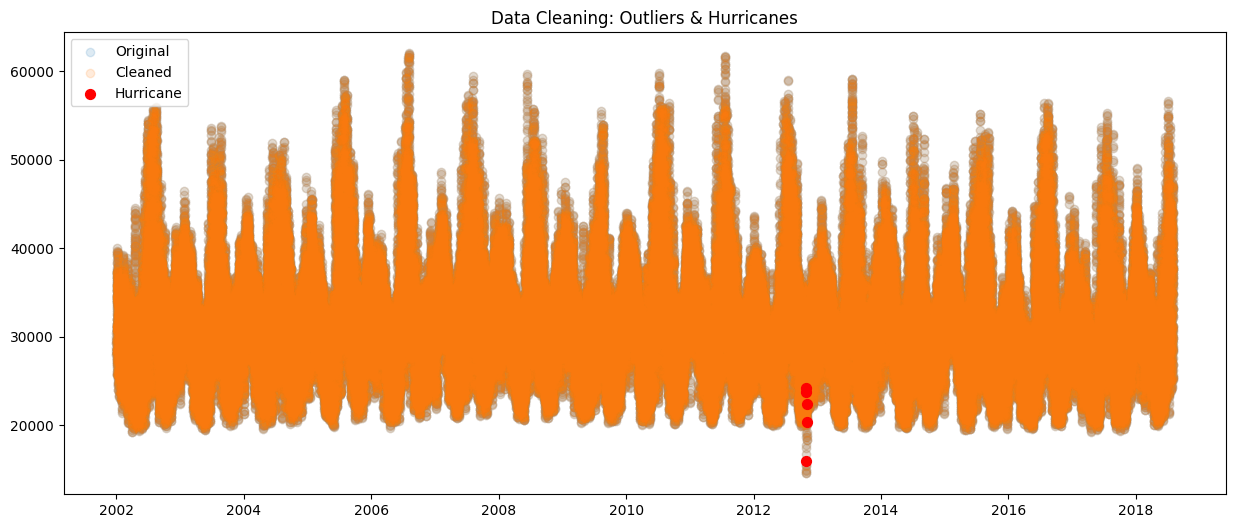

In [9]:
plt.figure(figsize=(15,6))
plt.scatter(df_clean['ds'], df_clean['y'], label='Original', alpha=0.15)
plt.scatter(df_clean['ds'], df_clean['y_clean'], label='Cleaned', alpha=0.15)
plt.scatter(df_clean[df_clean['is_hurricane']==1]['ds'], 
            df_clean[df_clean['is_hurricane']==1]['y'],
            color='red', s=50, label='Hurricane')
plt.legend()
plt.title('Data Cleaning: Outliers & Hurricanes')
plt.show()

In [ ]:
def objective(trial):
    """
    Objective function to optimize Prophet model hyperparameters along with the cleaning parameters.

    Uses cross-validation with specified settings and returns the mean MAPE.
    """
    # Clean the training data using hyperparameter suggestions from the trial
    cleaned_train, hurricane_dates = clean_train_data(trial, full_train)
    
    # Prophet hyperparameter suggestions from the trial
    prophet_params = {
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.01, 0.5),
        'seasonality_prior_scale': trial.suggest_float('seasonality_prior_scale', 0.1, 10.0),
        'holidays_prior_scale': trial.suggest_float('holidays_prior_scale', 5, 20),
        'seasonality_mode': trial.suggest_categorical('seasonality_mode', ['multiplicative', 'additive']),
        'yearly_seasonality': trial.suggest_int('yearly_seasonality', 6, 12)
    }
    
    # Initialize the Prophet model using the provided parameters and hurricane dates
    model = Prophet(
        **prophet_params,
        holidays=hurricane_dates,
        daily_seasonality=False,
        weekly_seasonality=False
        )
    model.add_country_holidays('US')
    
    # Fit the model on the cleaned training data.
    try:
        model.fit(cleaned_train)
    except Exception as e:
        print(f"Fitting failed: {str(e)}")
        return 100.0  # Return a high error if the fitting fails
    
    # Perform cross-validation to evaluate the model's performance
    try:
        df_cv = cross_validation(
            model,
            initial='366 days',
            period='30 days',
            horizon='30 days',
            disable_tqdm=True,
            parallel="processes"
        )
        df_p = performance_metrics(df_cv, rolling_window=1)
        mape = df_p['mape'].mean()
    except Exception as e:
        print(f"Validation failed: {str(e)}")
        mape = 100.0  # Penalize invalid configurations
    
    return mape

if __name__ == "__main__":
    # Create an Optuna study to minimize MAPE
    study = optuna.create_study(
        direction='minimize',
        sampler=optuna.samplers.TPESampler(seed=42)
    )
    
    # Optimize the objective function with a maximum of 100 trials or 6 hours of runtime
    study.optimize(objective, n_trials=20, timeout=3600 * 6)
    
    print(f"Best MAPE: {study.best_value:.2f}%") # print(f"Best MAPE: {study.best_value * 100:.2f}%")
    print("Best params:")
    for key, value in study.best_params.items():
        print(f"- {key}: {value}")

[I 2025-04-10 17:27:32,119] A new study created in memory with name: no-name-0e1abe3c-d21d-442b-8e57-8906c515a0b4
17:28:49 - cmdstanpy - INFO - Chain [1] start processing
17:31:29 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
17:32:38 - cmdstanpy - INFO - Chain [1] start processing
17:32:38 - cmdstanpy - INFO - Chain [1] start processing
17:32:39 - cmdstanpy - INFO - Chain [1] start processing
17:32:39 - cmdstanpy - INFO - Chain [1] start processing
17:33:05 - cmdstanpy - INFO - Chain [1] done processing
17:33:14 - cmdstanpy - INFO - Chain [1] start processing
17:33:17 - cmdstanpy - INFO - Chain [1] done processing
17:33:25 - cmdstanpy - INFO - Chain [1] start processing
17:33:39 - cmdstanpy - INFO - Chain [1] done processing
17:33:40 - cmdstanpy - INFO - C

Best MAPE: 0.14%
Best params:
- window_size: 186
- iqr_multiplier: 2.8736874205941256
- hurricane_window: 4
- changepoint_prior_scale: 0.0783519917195005
- seasonality_prior_scale: 2.99223202049866
- holidays_prior_scale: 10.495427649405375
- seasonality_mode: additive
- yearly_seasonality: 7
